# View mnist.pkl.gz

In [8]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import gzip
import pickle

In [3]:
%matplotlib inline

In [9]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f) #mnist.pkl is a tuple with length 3

In [10]:
train_x, train_y = train_set

In [11]:
train_x

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [12]:
train_y

array([5, 0, 4, ..., 8, 4, 8])

In [13]:
len(train_y)

50000

In [16]:
len(train_x)

50000

In [17]:
len(train_x[0])

784

由此可以看出，train_x是$50000\times 784$的矩阵，表明有50000个样本，每个样本长度为$784=28^2$，是像素尺度为$28\times 28$的图象。

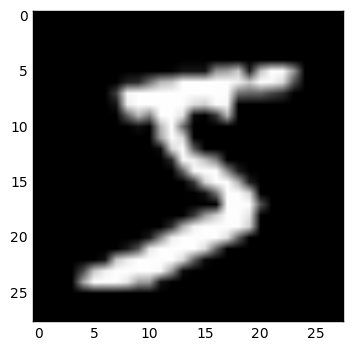

In [18]:
plt.imshow(train_x[0].reshape((28, 28)), cmap = cm.Greys_r)

# rbm code

In [20]:
from __future__ import print_function

import timeit

try:
    import PIL.Image as Image
except ImportError:
    import Image

import numpy

import theano
import theano.tensor as T
import os

from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

from utils import tile_raster_images
from logistic_sgd import load_data

In [21]:
class RBM(object):
    """Restricted Boltzmann Machine (RBM)  """
    def __init__(
        self,
        input=None,
        n_visible=784,
        n_hidden=500,
        W=None,
        hbias=None,
        vbias=None,
        numpy_rng=None,
        theano_rng=None
    ):
        """
        RBM constructor. Defines the parameters of the model along with
        basic operations for inferring hidden from visible (and vice-versa),
        as well as for performing CD updates.

        :param input: None for standalone RBMs or symbolic variable if RBM is
        part of a larger graph.

        :param n_visible: number of visible units

        :param n_hidden: number of hidden units

        :param W: None for standalone RBMs or symbolic variable pointing to a
        shared weight matrix in case RBM is part of a DBN network; in a DBN,
        the weights are shared between RBMs and layers of a MLP

        :param hbias: None for standalone RBMs or symbolic variable pointing
        to a shared hidden units bias vector in case RBM is part of a
        different network

        :param vbias: None for standalone RBMs or a symbolic variable
        pointing to a shared visible units bias
        """

        self.n_visible = n_visible
        self.n_hidden = n_hidden

        if numpy_rng is None:
            # create a number generator
            numpy_rng = numpy.random.RandomState(1234)

        if theano_rng is None:
            theano_rng = RandomStreams(numpy_rng.randint(2 ** 30))

        if W is None:
            # W is initialized with `initial_W` which is uniformely
            # sampled from -4*sqrt(6./(n_visible+n_hidden)) and
            # 4*sqrt(6./(n_hidden+n_visible)) the output of uniform if
            # converted using asarray to dtype theano.config.floatX so
            # that the code is runable on GPU
            initial_W = numpy.asarray(
                numpy_rng.uniform(
                    low=-4 * numpy.sqrt(6. / (n_hidden + n_visible)),
                    high=4 * numpy.sqrt(6. / (n_hidden + n_visible)),
                    size=(n_visible, n_hidden)
                ),
                dtype=theano.config.floatX
            )
            # theano shared variables for weights and biases
            W = theano.shared(value=initial_W, name='W', borrow=True)

        if hbias is None:
            # create shared variable for hidden units bias
            hbias = theano.shared(
                value=numpy.zeros(
                    n_hidden,
                    dtype=theano.config.floatX
                ),
                name='hbias',
                borrow=True
            )

        if vbias is None:
            # create shared variable for visible units bias
            vbias = theano.shared(
                value=numpy.zeros(
                    n_visible,
                    dtype=theano.config.floatX
                ),
                name='vbias',
                borrow=True
            )

        # initialize input layer for standalone RBM or layer0 of DBN
        self.input = input
        if not input:
            self.input = T.matrix('input')

        self.W = W
        self.hbias = hbias
        self.vbias = vbias
        self.theano_rng = theano_rng
        # **** WARNING: It is not a good idea to put things in this list
        # other than shared variables created in this function.
        self.params = [self.W, self.hbias, self.vbias]
        # end-snippet-1

    def free_energy(self, v_sample):
        ''' Function to compute the free energy '''
        wx_b = T.dot(v_sample, self.W) + self.hbias
        vbias_term = T.dot(v_sample, self.vbias)
        hidden_term = T.sum(T.log(1 + T.exp(wx_b)), axis=1)
        return -hidden_term - vbias_term

    def propup(self, vis):
        '''This function propagates the visible units activation upwards to
        the hidden units

        Note that we return also the pre-sigmoid activation of the
        layer. As it will turn out later, due to how Theano deals with
        optimizations, this symbolic variable will be needed to write
        down a more stable computational graph (see details in the
        reconstruction cost function)

        '''
        pre_sigmoid_activation = T.dot(vis, self.W) + self.hbias
        return [pre_sigmoid_activation, T.nnet.sigmoid(pre_sigmoid_activation)]

    def sample_h_given_v(self, v0_sample):
        ''' This function infers state of hidden units given visible units '''
        # compute the activation of the hidden units given a sample of
        # the visibles
        pre_sigmoid_h1, h1_mean = self.propup(v0_sample)
        # get a sample of the hiddens given their activation
        # Note that theano_rng.binomial returns a symbolic sample of dtype
        # int64 by default. If we want to keep our computations in floatX
        # for the GPU we need to specify to return the dtype floatX
        h1_sample = self.theano_rng.binomial(size=h1_mean.shape,
                                             n=1, p=h1_mean,
                                             dtype=theano.config.floatX)
        return [pre_sigmoid_h1, h1_mean, h1_sample]

    def propdown(self, hid):
        '''This function propagates the hidden units activation downwards to
        the visible units

        Note that we return also the pre_sigmoid_activation of the
        layer. As it will turn out later, due to how Theano deals with
        optimizations, this symbolic variable will be needed to write
        down a more stable computational graph (see details in the
        reconstruction cost function)

        '''
        pre_sigmoid_activation = T.dot(hid, self.W.T) + self.vbias
        return [pre_sigmoid_activation, T.nnet.sigmoid(pre_sigmoid_activation)]

    def sample_v_given_h(self, h0_sample):
        ''' This function infers state of visible units given hidden units '''
        # compute the activation of the visible given the hidden sample
        pre_sigmoid_v1, v1_mean = self.propdown(h0_sample)
        # get a sample of the visible given their activation
        # Note that theano_rng.binomial returns a symbolic sample of dtype
        # int64 by default. If we want to keep our computations in floatX
        # for the GPU we need to specify to return the dtype floatX
        v1_sample = self.theano_rng.binomial(size=v1_mean.shape,
                                             n=1, p=v1_mean,
                                             dtype=theano.config.floatX)
        return [pre_sigmoid_v1, v1_mean, v1_sample]

    def gibbs_hvh(self, h0_sample):
        ''' This function implements one step of Gibbs sampling,
            starting from the hidden state'''
        pre_sigmoid_v1, v1_mean, v1_sample = self.sample_v_given_h(h0_sample)
        pre_sigmoid_h1, h1_mean, h1_sample = self.sample_h_given_v(v1_sample)
        return [pre_sigmoid_v1, v1_mean, v1_sample,
                pre_sigmoid_h1, h1_mean, h1_sample]

    def gibbs_vhv(self, v0_sample):
        ''' This function implements one step of Gibbs sampling,
            starting from the visible state'''
        pre_sigmoid_h1, h1_mean, h1_sample = self.sample_h_given_v(v0_sample)
        pre_sigmoid_v1, v1_mean, v1_sample = self.sample_v_given_h(h1_sample)
        return [pre_sigmoid_h1, h1_mean, h1_sample,
                pre_sigmoid_v1, v1_mean, v1_sample]

    # start-snippet-2
    def get_cost_updates(self, lr=0.1, persistent=None, k=1):
        """This functions implements one step of CD-k or PCD-k

        :param lr: learning rate used to train the RBM

        :param persistent: None for CD. For PCD, shared variable
            containing old state of Gibbs chain. This must be a shared
            variable of size (batch size, number of hidden units).

        :param k: number of Gibbs steps to do in CD-k/PCD-k

        Returns a proxy for the cost and the updates dictionary. The
        dictionary contains the update rules for weights and biases but
        also an update of the shared variable used to store the persistent
        chain, if one is used.

        """

        # compute positive phase
        pre_sigmoid_ph, ph_mean, ph_sample = self.sample_h_given_v(self.input)

        # decide how to initialize persistent chain:
        # for CD, we use the newly generate hidden sample
        # for PCD, we initialize from the old state of the chain
        if persistent is None:
            chain_start = ph_sample
        else:
            chain_start = persistent
        # end-snippet-2
        # perform actual negative phase
        # in order to implement CD-k/PCD-k we need to scan over the
        # function that implements one gibbs step k times.
        # Read Theano tutorial on scan for more information :
        # http://deeplearning.net/software/theano/library/scan.html
        # the scan will return the entire Gibbs chain
        (
            [
                pre_sigmoid_nvs,
                nv_means,
                nv_samples,
                pre_sigmoid_nhs,
                nh_means,
                nh_samples
            ],
            updates
        ) = theano.scan(
            self.gibbs_hvh,
            # the None are place holders, saying that
            # chain_start is the initial state corresponding to the
            # 6th output
            outputs_info=[None, None, None, None, None, chain_start],
            n_steps=k,
            name="gibbs_hvh"
        )
        # start-snippet-3
        # determine gradients on RBM parameters
        # note that we only need the sample at the end of the chain
        chain_end = nv_samples[-1]

        cost = T.mean(self.free_energy(self.input)) - T.mean(
            self.free_energy(chain_end))
        # We must not compute the gradient through the gibbs sampling
        gparams = T.grad(cost, self.params, consider_constant=[chain_end])
        # end-snippet-3 start-snippet-4
        # constructs the update dictionary
        for gparam, param in zip(gparams, self.params):
            # make sure that the learning rate is of the right dtype
            updates[param] = param - gparam * T.cast(
                lr,
                dtype=theano.config.floatX
            )
        if persistent:
            # Note that this works only if persistent is a shared variable
            updates[persistent] = nh_samples[-1]
            # pseudo-likelihood is a better proxy for PCD
            monitoring_cost = self.get_pseudo_likelihood_cost(updates)
        else:
            # reconstruction cross-entropy is a better proxy for CD
            monitoring_cost = self.get_reconstruction_cost(updates,
                                                           pre_sigmoid_nvs[-1])

        return monitoring_cost, updates
        # end-snippet-4

    def get_pseudo_likelihood_cost(self, updates):
        """Stochastic approximation to the pseudo-likelihood"""

        # index of bit i in expression p(x_i | x_{\i})
        bit_i_idx = theano.shared(value=0, name='bit_i_idx')

        # binarize the input image by rounding to nearest integer
        xi = T.round(self.input)

        # calculate free energy for the given bit configuration
        fe_xi = self.free_energy(xi)

        # flip bit x_i of matrix xi and preserve all other bits x_{\i}
        # Equivalent to xi[:,bit_i_idx] = 1-xi[:, bit_i_idx], but assigns
        # the result to xi_flip, instead of working in place on xi.
        xi_flip = T.set_subtensor(xi[:, bit_i_idx], 1 - xi[:, bit_i_idx])

        # calculate free energy with bit flipped
        fe_xi_flip = self.free_energy(xi_flip)

        # equivalent to e^(-FE(x_i)) / (e^(-FE(x_i)) + e^(-FE(x_{\i})))
        cost = T.mean(self.n_visible * T.log(T.nnet.sigmoid(fe_xi_flip -
                                                            fe_xi)))

        # increment bit_i_idx % number as part of updates
        updates[bit_i_idx] = (bit_i_idx + 1) % self.n_visible

        return cost

    def get_reconstruction_cost(self, updates, pre_sigmoid_nv):
        """Approximation to the reconstruction error

        Note that this function requires the pre-sigmoid activation as
        input.  To understand why this is so you need to understand a
        bit about how Theano works. Whenever you compile a Theano
        function, the computational graph that you pass as input gets
        optimized for speed and stability.  This is done by changing
        several parts of the subgraphs with others.  One such
        optimization expresses terms of the form log(sigmoid(x)) in
        terms of softplus.  We need this optimization for the
        cross-entropy since sigmoid of numbers larger than 30. (or
        even less then that) turn to 1. and numbers smaller than
        -30. turn to 0 which in terms will force theano to compute
        log(0) and therefore we will get either -inf or NaN as
        cost. If the value is expressed in terms of softplus we do not
        get this undesirable behaviour. This optimization usually
        works fine, but here we have a special case. The sigmoid is
        applied inside the scan op, while the log is
        outside. Therefore Theano will only see log(scan(..)) instead
        of log(sigmoid(..)) and will not apply the wanted
        optimization. We can not go and replace the sigmoid in scan
        with something else also, because this only needs to be done
        on the last step. Therefore the easiest and more efficient way
        is to get also the pre-sigmoid activation as an output of
        scan, and apply both the log and sigmoid outside scan such
        that Theano can catch and optimize the expression.

        """

        cross_entropy = T.mean(
            T.sum(
                self.input * T.log(T.nnet.sigmoid(pre_sigmoid_nv)) +
                (1 - self.input) * T.log(1 - T.nnet.sigmoid(pre_sigmoid_nv)),
                axis=1
            )
        )

        return cross_entropy


In [22]:
def test_rbm(learning_rate=0.1, training_epochs=15,
             dataset='mnist.pkl.gz', batch_size=20,
             n_chains=20, n_samples=10, output_folder='rbm_plots',
             n_hidden=500):
    """
    Demonstrate how to train and afterwards sample from it using Theano.

    This is demonstrated on MNIST.

    :param learning_rate: learning rate used for training the RBM

    :param training_epochs: number of epochs used for training

    :param dataset: path the the pickled dataset

    :param batch_size: size of a batch used to train the RBM

    :param n_chains: number of parallel Gibbs chains to be used for sampling

    :param n_samples: number of samples to plot for each chain

    """
    datasets = load_data(dataset)

    train_set_x, train_set_y = datasets[0]
    test_set_x, test_set_y = datasets[2]

    # compute number of minibatches for training, validation and testing
    n_train_batches = train_set_x.get_value(borrow=True).shape[0] // batch_size

    # allocate symbolic variables for the data
    index = T.lscalar()    # index to a [mini]batch
    x = T.matrix('x')  # the data is presented as rasterized images

    rng = numpy.random.RandomState(123)
    theano_rng = RandomStreams(rng.randint(2 ** 30))

    # initialize storage for the persistent chain (state = hidden
    # layer of chain)
    persistent_chain = theano.shared(numpy.zeros((batch_size, n_hidden),
                                                 dtype=theano.config.floatX),
                                     borrow=True)

    # construct the RBM class
    rbm = RBM(input=x, n_visible=28 * 28,
              n_hidden=n_hidden, numpy_rng=rng, theano_rng=theano_rng)

    # get the cost and the gradient corresponding to one step of CD-15
    cost, updates = rbm.get_cost_updates(lr=learning_rate,
                                         persistent=persistent_chain, k=15)

    #################################
    #     Training the RBM          #
    #################################
    if not os.path.isdir(output_folder):
        os.makedirs(output_folder)
    os.chdir(output_folder)

    # start-snippet-5
    # it is ok for a theano function to have no output
    # the purpose of train_rbm is solely to update the RBM parameters
    train_rbm = theano.function(
        [index],
        cost,
        updates=updates,
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size]
        },
        name='train_rbm'
    )

    plotting_time = 0.
    start_time = timeit.default_timer()

    # go through training epochs
    for epoch in range(training_epochs):

        # go through the training set
        mean_cost = []
        for batch_index in range(n_train_batches):
            mean_cost += [train_rbm(batch_index)]

        print('Training epoch %d, cost is ' % epoch, numpy.mean(mean_cost))

        # Plot filters after each training epoch
        plotting_start = timeit.default_timer()
        # Construct image from the weight matrix
        image = Image.fromarray(
            tile_raster_images(
                X=rbm.W.get_value(borrow=True).T,
                img_shape=(28, 28),
                tile_shape=(10, 10),
                tile_spacing=(1, 1)
            )
        )
        image.save('filters_at_epoch_%i.png' % epoch)
        plotting_stop = timeit.default_timer()
        plotting_time += (plotting_stop - plotting_start)

    end_time = timeit.default_timer()

    pretraining_time = (end_time - start_time) - plotting_time

    print ('Training took %f minutes' % (pretraining_time / 60.))
    # end-snippet-5 start-snippet-6
    #################################
    #     Sampling from the RBM     #
    #################################
    # find out the number of test samples
    number_of_test_samples = test_set_x.get_value(borrow=True).shape[0]

    # pick random test examples, with which to initialize the persistent chain
    test_idx = rng.randint(number_of_test_samples - n_chains)
    persistent_vis_chain = theano.shared(
        numpy.asarray(
            test_set_x.get_value(borrow=True)[test_idx:test_idx + n_chains],
            dtype=theano.config.floatX
        )
    )
    # end-snippet-6 start-snippet-7
    plot_every = 1000
    # define one step of Gibbs sampling (mf = mean-field) define a
    # function that does `plot_every` steps before returning the
    # sample for plotting
    (
        [
            presig_hids,
            hid_mfs,
            hid_samples,
            presig_vis,
            vis_mfs,
            vis_samples
        ],
        updates
    ) = theano.scan(
        rbm.gibbs_vhv,
        outputs_info=[None, None, None, None, None, persistent_vis_chain],
        n_steps=plot_every,
        name="gibbs_vhv"
    )

    # add to updates the shared variable that takes care of our persistent
    # chain :.
    updates.update({persistent_vis_chain: vis_samples[-1]})
    # construct the function that implements our persistent chain.
    # we generate the "mean field" activations for plotting and the actual
    # samples for reinitializing the state of our persistent chain
    sample_fn = theano.function(
        [],
        [
            vis_mfs[-1],
            vis_samples[-1]
        ],
        updates=updates,
        name='sample_fn'
    )

    # create a space to store the image for plotting ( we need to leave
    # room for the tile_spacing as well)
    image_data = numpy.zeros(
        (29 * n_samples + 1, 29 * n_chains - 1),
        dtype='uint8'
    )
    for idx in range(n_samples):
        # generate `plot_every` intermediate samples that we discard,
        # because successive samples in the chain are too correlated
        vis_mf, vis_sample = sample_fn()
        print(' ... plotting sample %d' % idx)
        image_data[29 * idx:29 * idx + 28, :] = tile_raster_images(
            X=vis_mf,
            img_shape=(28, 28),
            tile_shape=(1, n_chains),
            tile_spacing=(1, 1)
        )

    # construct image
    image = Image.fromarray(image_data)
    image.save('samples.png')
    # end-snippet-7
    os.chdir('../')

In [23]:
test_rbm()

... loading data
Training epoch 0, cost is  -90.590108121
Training epoch 1, cost is  -80.306465234
Training epoch 2, cost is  -74.3871721077
Training epoch 3, cost is  -72.2911275348
Training epoch 4, cost is  -68.7493255098
Training epoch 5, cost is  -63.3319654523
Training epoch 6, cost is  -65.6836096852
Training epoch 7, cost is  -67.5699326992
Training epoch 8, cost is  -68.1104919343
Training epoch 9, cost is  -64.2462694866
Training epoch 10, cost is  -61.3355699009
Training epoch 11, cost is  -62.0303931597
Training epoch 12, cost is  -64.0581166301
Training epoch 13, cost is  -63.4414152005
Training epoch 14, cost is  -62.7701948813
Training took 71.232035 minutes
 ... plotting sample 0
 ... plotting sample 1
 ... plotting sample 2
 ... plotting sample 3
 ... plotting sample 4
 ... plotting sample 5
 ... plotting sample 6
 ... plotting sample 7
 ... plotting sample 8
 ... plotting sample 9


![](rbm_plots/samples.png)

# Basic about theano

In [1]:
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

In [4]:
import numpy

In [5]:
numpy_rng = numpy.random.RandomState(1234)

In [2]:
help(RandomStreams)

Help on class MRG_RandomStreams in module theano.sandbox.rng_mrg:

class MRG_RandomStreams(__builtin__.object)
 |  Module component with similar interface to numpy.random
 |  (numpy.random.RandomState).
 |  
 |  Parameters
 |  ----------
 |  seed : int or list of 6 int
 |      A default seed to initialize the random state.
 |      If a single int is given, it will be replicated 6 times.
 |      The first 3 values of the seed must all be less than M1 = 2147483647,
 |      and not all 0; and the last 3 values must all be less than
 |      M2 = 2147462579, and not all 0.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, seed=12345, use_cuda=None)
 |  
 |  binomial(self, size=None, n=1, p=0.5, ndim=None, dtype='int64', nstreams=None)
 |  
 |  get_substream_rstates(self, n_streams, dtype, inc_rstate=True)
 |      Initialize a matrix in which each row is a MRG stream state,
 |      and they are spaced by 2**72 samples.
 |  
 |  inc_rstate(self)
 |      Update self.rstate to be skipped 2

In [6]:
theano_rng = RandomStreams(numpy_rng.randint(2 ** 30))

In [7]:
theano_rng

In [12]:
theano_rng.binomial(size=(100,10))# size is tupe of int or theano variables

Elemwise{Cast{int64}}.0

In [14]:
test = theano_rng.binomial(size=(100,10), p=0.4)

In [15]:
print(test)

Elemwise{Cast{int64}}.0
